# Titanic Survival Predictions for Beginners

The goal of this notebook is to use the Titanic passenger data to predict who will survive the crash using machine learning.

We use datasets from https://www.kaggle.com/c/titanic/data

### Contents:
1. Importing the neccessary libraries
2. Importing the data
3. Analyzing the data
4. Visualizing the data
5. Cleaning and processing the data
6. Modelling the data

## 1. Importing the neccessary libraries 

In [1]:
# Data processing, CSV file I/O
import pandas as pd

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("white")

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## 2. Importing the data

We import our data from a CSV file using a Python library called pandas (abbreviated as pd)

In [2]:
# Import passenger data from CSV file
data = pd.read_csv("./input/data.csv")

## 3. Analyzing the data

An import step in our workflow is to analyze our data to gain a better understanding of what we're working with. We want to know what kind of features we have for each passenger, as well as if any data is missing.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### We have three distinct classes of features:
* Numerical Features:
    - **Age**: float
    - **Fare**: float
    - **SibSp** (# of siblings/spouses): int
    - **Parch** (# of parents/children): int
* Categorical Features:
    - **Survived**: int (0 = No, 1 = Yes)
    - **Sex**: string
    - **Embarked**: string (C = Cherbourg, Q = Queenstown, S = Southampton)
    - **Pclass** (ticket class): int (1 = 1st, 2 = 2nd, 3 = 3rd)
* Alphanumeric Features:
    - **Ticket**: string
    - **Cabin**: string
    
#### There are 891 passengers in our dataset, but some columns are missing data
* The age column is missing 19.8% of its values. Age is probably an important feature for survival so we will try to fill in these gaps
* The cabin column is missing 77.1% of its values. While which cabin a passenger was in is probably an important feature, with so much missing data we will probably drop this column.
* The embarked column is only missing 0.22% of its values, which shouldn't be a problem.

In [4]:
data["Survived"].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

Just over a third of the passengers survived.

## 4. Visualizing the data

We now plot how different features relate to the survival chances of a passenger. We can make some predictions beforehand and see if they're backed up by the data.

#### Predictions:
* Females and young children are more likely to survive as "women and children first"
* People of higher class are more likely to survive as they would get first access to lifeboats and don't have to settle for floating doors

What predictions do you make?

In [5]:
def survival_rate_barplot(feature):
    plt.figure(figsize=(12, 3), dpi=250) # Set size and resolution of plot
    sns.barplot(x=feature, y="Survived", data=data) # Create barplot
    sns.despine() # Remove top and right spine from plot
    plt.show() # Show plot

### Sex feature

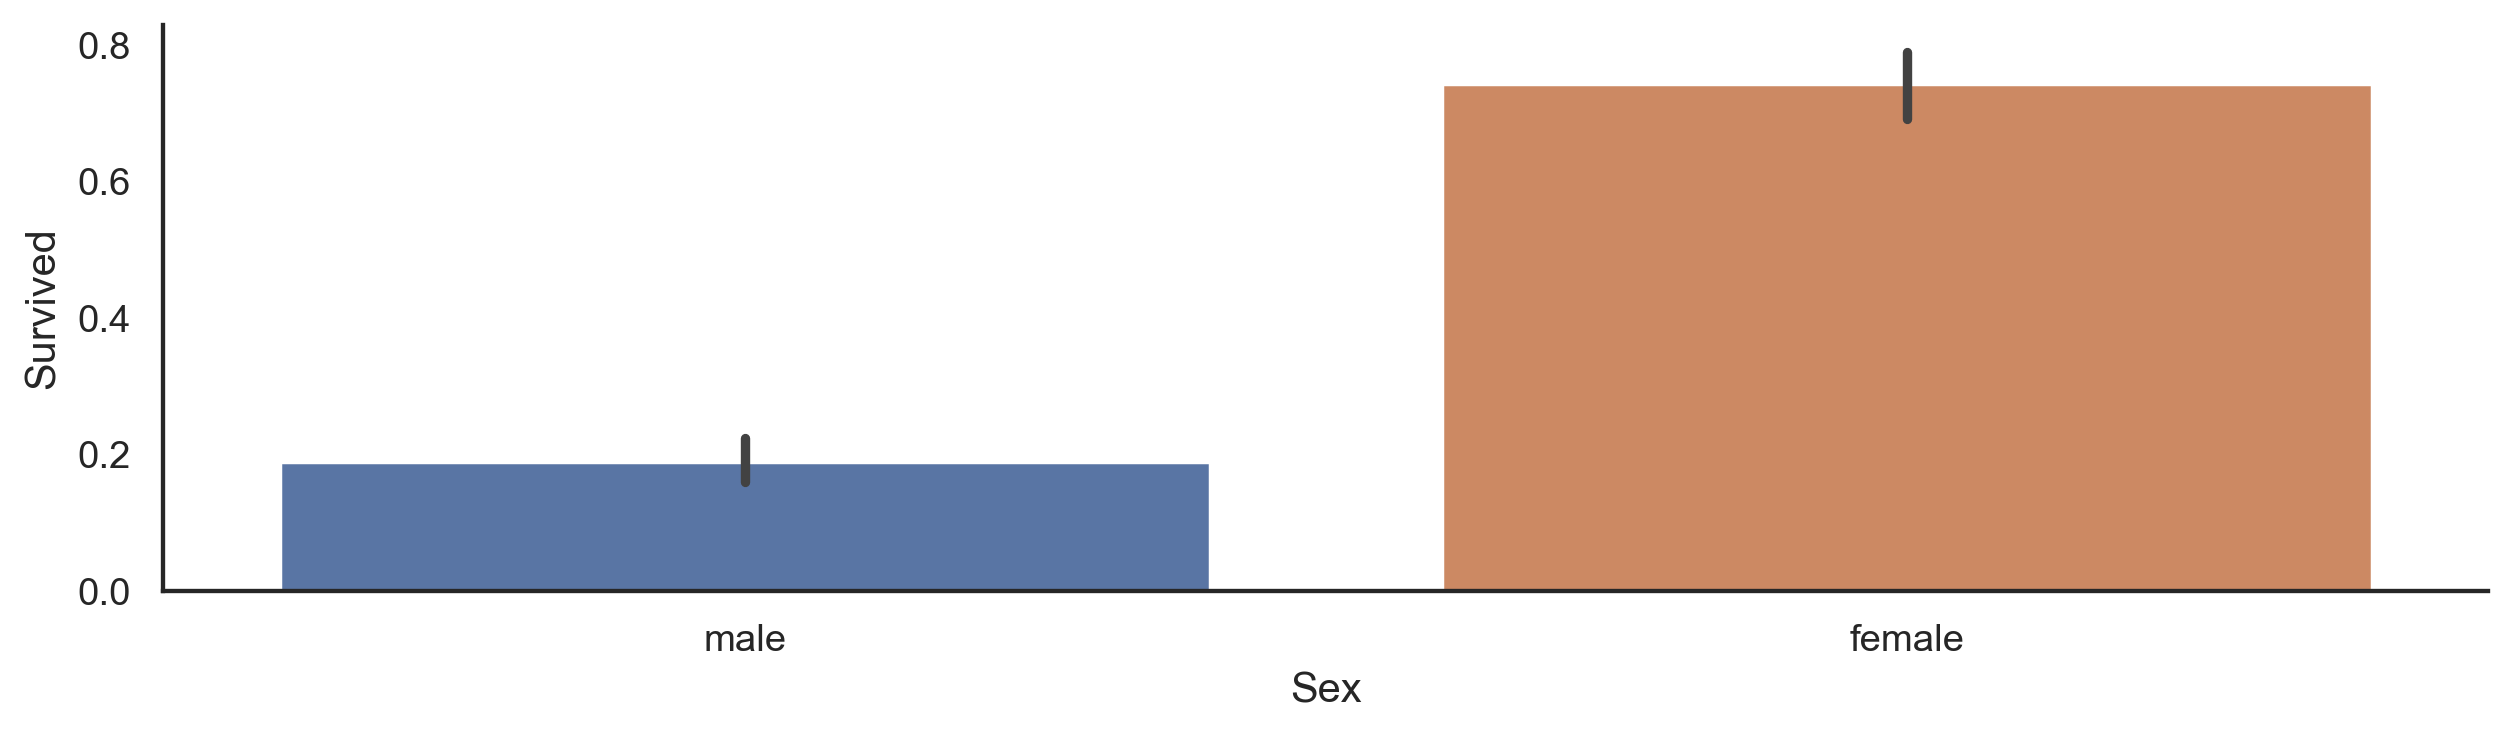

Female survival rate = 0.7420382165605095
Male survival rate = 0.18890814558058924


In [6]:
survival_rate_barplot("Sex")

female_survival_rate = data[data["Sex"] == "female"]["Survived"].value_counts(normalize=True)[1]
male_survival_rate = data[data["Sex"] == "male"]["Survived"].value_counts(normalize=True)[1]

print(f"Female survival rate = {female_survival_rate}")
print(f"Male survival rate = {male_survival_rate}")

We see that females are far more likely to surive than males, almost three times in fact!

### Class feature

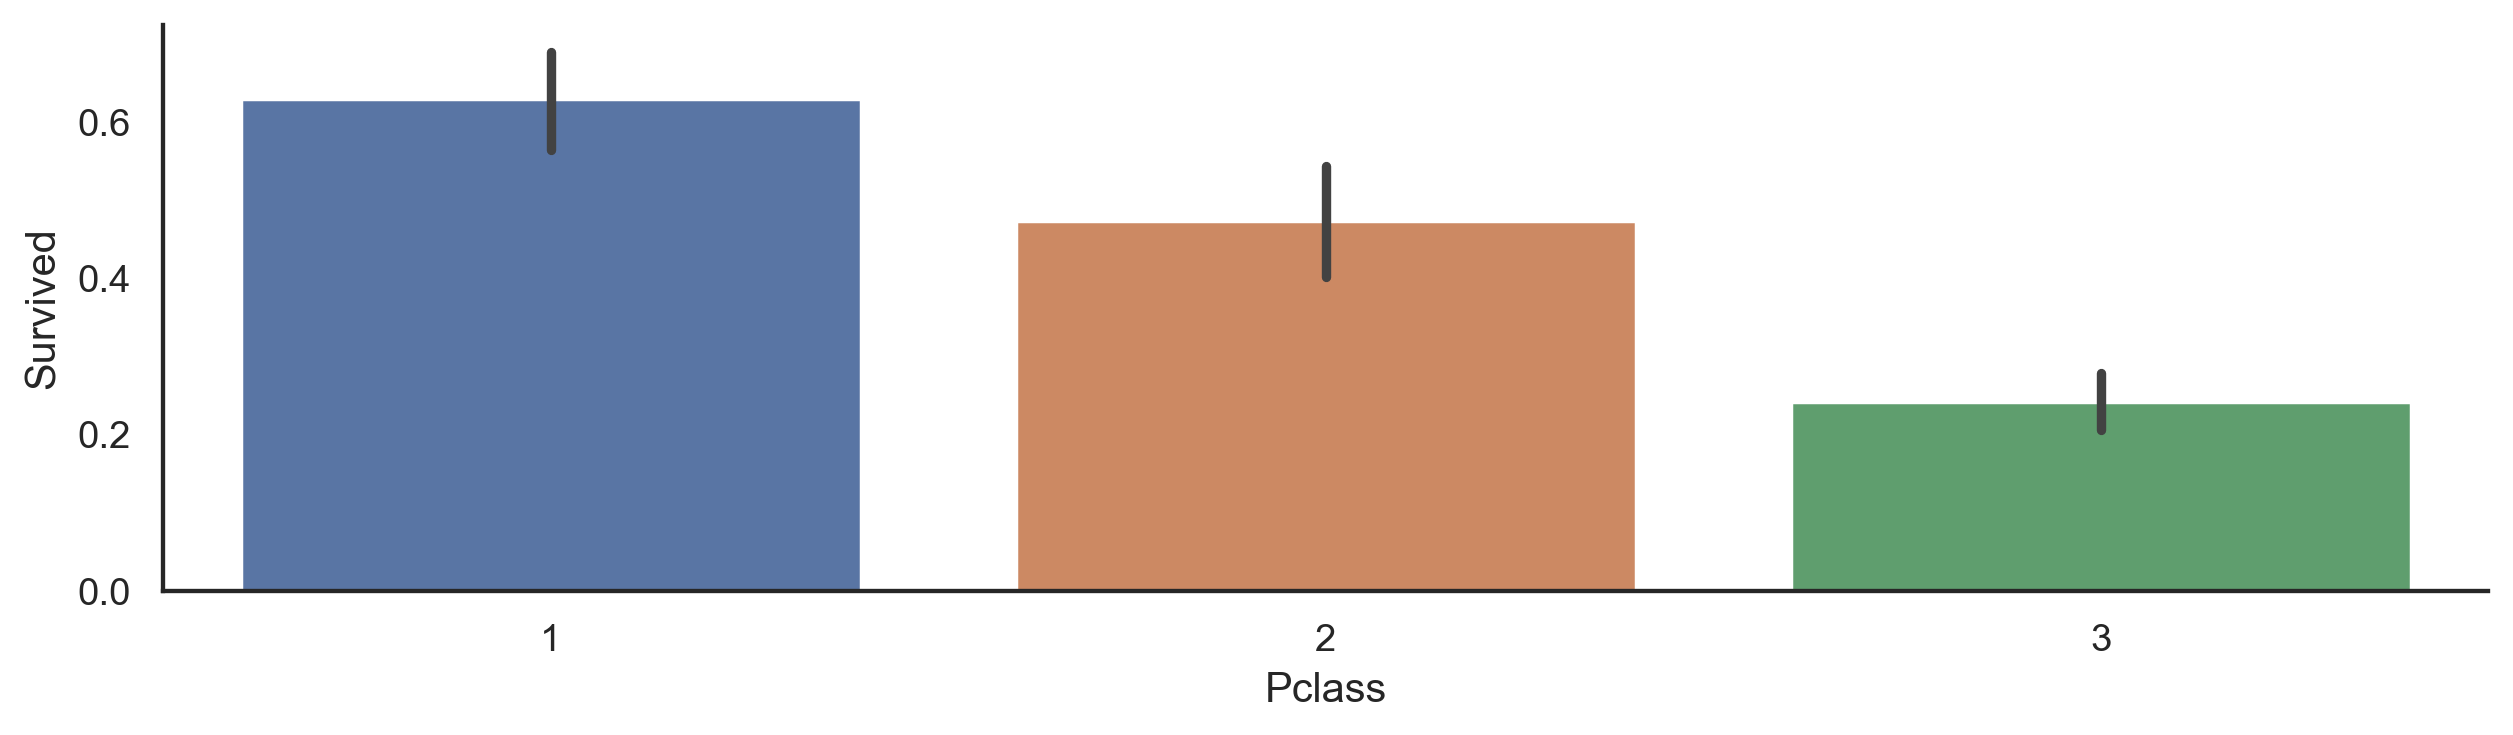

First class survival rate = 0.6296296296296297
Second class survival rate = 0.47282608695652173
Third class survival rate = 0.24236252545824846


In [7]:
survival_rate_barplot("Pclass")

class1_survival_rate = data[data["Pclass"] == 1]["Survived"].value_counts(normalize=True)[1]
class2_survival_rate = data[data["Pclass"] == 2]["Survived"].value_counts(normalize=True)[1]
class3_survival_rate = data[data["Pclass"] == 3]["Survived"].value_counts(normalize=True)[1]

print(f"First class survival rate = {class1_survival_rate}")
print(f"Second class survival rate = {class2_survival_rate}")
print(f"Third class survival rate = {class3_survival_rate}")

We see that, as predicted, the higher (or numerically lower) class a passenger is in, the better their survival rate.

### Age feature

For the age feature we need to do a bit of work before we can plot as there are too many different ages to find any trends.

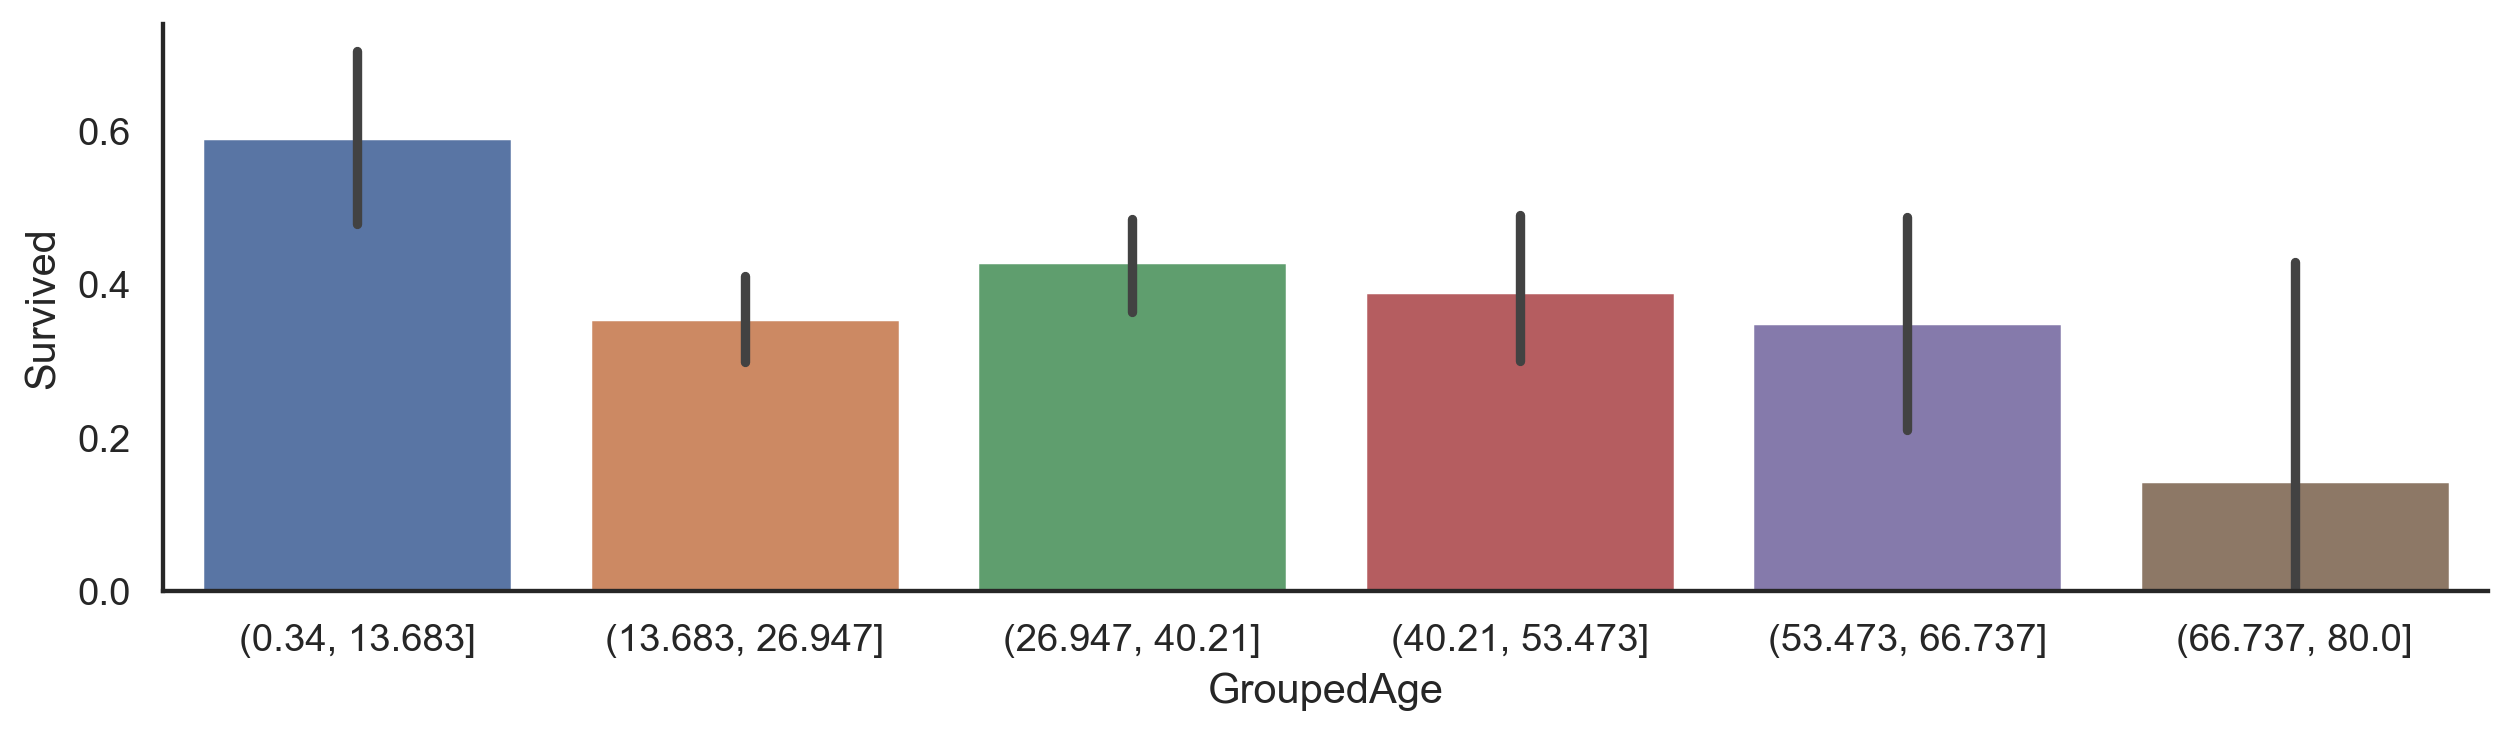

In [8]:
data["GroupedAge"] = pd.cut(data["Age"], bins=6) # Divide age range into 6 groups
survival_rate_barplot("GroupedAge")
data = data.drop(["GroupedAge"], axis=1) # Drop age groups from dataframe

Once we group the ages, we see that young children under the age of 13 were the most likely to surive and elders above 66 years old were the least likely.

We do however see that the error bar for the elder groups are much larger than those of the other groups, showing that there's a large amount of uncertainty there. This could be explained by the fact that there were a lot of wealthy older people onboard, so maybe being in a better class offset their age, relative to survival rates.

## 5. Cleaning and processing the data

While we could build a model that looks at all the data in its current form to make a prediction, it is usually more effective to clean and process the data beforehand.

#### Steps:
1. Drop features that we don't think have an effect on survival rates
2. Fill in missing values with educated guesses
3. Group continuous features like fare and age into bands
4. Map categorical values to numerical values 

In [9]:
# Drop inconsequential features
data = data.drop(["Cabin", "Ticket", "PassengerId", "Name"], axis=1)

# Fill missing embarked values with most common embarkement, which is "S" for Southampton
data = data.fillna({"Embarked": data["Embarked"].mode()[0]})

# Fill missing age values with mean age, which is 29.7
data = data.fillna({"Age": data["Age"].mean()})

# Fill in missing fare values with mean fare, which is 32.2
data = data.fillna({"Fare": data["Fare"].mean()})

# Group ages into 6 bands and drop original age feature
data["AgeBand"] = pd.cut(data["Age"], bins=6, labels=False)
data = data.drop(["Age"], axis=1)

# Group fares into 4 bands and drop original fare feature,
data["FareBand"] = pd.cut(data["Fare"], bins=4, labels=False)
data = data.drop(["Fare"], axis=1)

# Map each sex value to a numerical value
data["Sex"] = data["Sex"].map({"male": 0, "female": 1})

# Map each embarked value to a numerical value
data["Embarked"] = data["Embarked"].map({'S': 0, 'C': 1, 'Q': 2})

In [10]:
data.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,AgeBand,FareBand
0,0,3,0,1,0,0,1,0
1,1,1,1,1,0,1,2,0
2,1,3,1,0,0,0,1,0
3,1,1,1,1,0,0,2,0
4,0,3,0,0,0,0,2,0


Lastly, we divide our dataset into a train and a test set. This is a common setup in data science as we want to be able train our model on one dataset and then evaluate it on another.

Think of it as if you were studying for an exam and the past papers are your training dataset. They have questions and answers. By studying them you can get a pretty good idea of what will be on the actual exam. But you can't ever see the actual exam until you take it, or that would be cheating and you wouldn't get a good evaluation of how well you know the material.

The same goes for machine learning models; you should only evaluate them on data they haven't seen before. Otherwise you won't have a good estimation of how they will do on unseen data, which is the most important metric in the real world.

We use 20% of our data for the test set so that we still have a good amount of data to train the model on but also enough to properly evaluate it.

In [11]:
# Initialize random state for reproducible results
random_state = 1234

inputs = data.drop("Survived", axis=1)
labels = data["Survived"]

(
    train_inputs,
    test_inputs,
    train_labels,
    test_labels
) = train_test_split(inputs, labels, test_size=0.25, random_state=random_state)

## 6. Modelling the data

Our task is to create a model that takes in a passenger's feature vector and output whether it is more likely that the passenger survives or doesn't. Such models are called classifiers and we will look at two that are closely related to eachother: decision trees and random forests. We use implementations provided by scikit-learn, a very popular Python data science library.

#### Decision Tree Classifier:
Fitting the model happens by building a tree where each node is a test on the feature vector (ex. "Age" > 60) and each branch stemming from that node represents the outcome of the test (ex. all passengers with "Age" > 60 would go down one branch, all passengers with "Age" <= 60 would go down the other). Nodes are fitted until the strong majority of passengers in any given leaf of the tree are of the same class. The leaf then assumes the label of the majority class. While it would be possible to continue growing the tree until all leaves only have one class in them, that tends to lead to overfitting. The root node test is chosen stochastically, meaning that the performance of each fit might vary. Once fitted, the model classifies by running the feature vector through the tree until it reaches a leaf and is classified by the label of that leaf.

Documentation: https://scikit-learn.org/stable/modules/tree.html


#### Random Forest Classifier:
Because decision trees are fitted stochastically, we can fit multiple decision trees on the same dataset then use the most common label from them to classify our passengers. Using multiple individual classifiers as a group is called ensemble learning. Here we create a "random forest" of 100 decision trees and then take the label that the majority of the trees select.

Documentation: https://scikit-learn.org/stable/modules/ensemble.html#forest

In [12]:
decision_tree = DecisionTreeClassifier(random_state=random_state)
decision_tree.fit(train_inputs, train_labels)
print(f"Decision tree train accuracy: {round(decision_tree.score(train_inputs, train_labels), 3)}")
print(f"Decision tree test accuracy: {round(decision_tree.score(test_inputs, test_labels), 3)}")

random_forest = RandomForestClassifier(n_estimators=100, random_state=random_state)
random_forest.fit(train_inputs, train_labels)
print(f"Random forest train accuracy: {round(random_forest.score(train_inputs, train_labels), 3)}")
print(f"Random forest test accuracy: {round(random_forest.score(test_inputs, test_labels), 3)}")

Decision tree train accuracy: 0.874
Decision tree test accuracy: 0.798
Random forest train accuracy: 0.874
Random forest test accuracy: 0.812


We see that the random forest classifer performs marginally better than the lone decision tree, which is to be expected as it can leverage the combined capabilities of many decision trees.

We also see that the classifiers perform better on the training data than test data. This is because the model was fit on that data so it is logical that it performs better. Using the previous analogy, it's like comparing taking an exam you've already taken before or taking a new one.

## Conclusions
And there we have it, a basic machine learning pipeline where we analyze and process the data before fitting and evaluating a couple different models. There's certainly room for improvement in both the data proccessing as well as the modelling complexity, but the goal was to give you an end to end taste of machine learning on an interesting and (not very) relevant problem!

#### Some questions for keen students:
* How would we make better estimations for missing passenger data? (ex. use the mean age given the class that the passenger is travelling in)
* What new features could we create to augment the dataset? (ex. use the titles in passenger's names to determine social class)
* Who might our dataset be biased towards and how could we offset those biases?
* If we wanted to update the classifier to work with modern ship crashes, what might we change? (ex. reduce the importance of gender as women and children might not be first this time)